### Imports

In [1]:
import torch
import scico.numpy as snp
from scico import functional, linop, loss, metric, plot, random
from scico.examples import create_3d_foam_phantom, downsample_volume, tile_volume_slices
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()
import matplotlib.pyplot as plt

### Data Loading

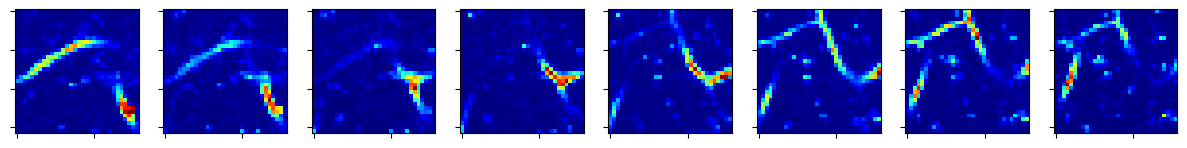

In [31]:
phi_comp=torch.load("./data/dataset/D2NN/A.pt")['matrix']
X = torch.load("./data/dataset/D2NN/Xr_blood_cell.pt")
Y = torch.load("./data/dataset/D2NN/Y_blood_cell.pt")

b = 232
n_measure = 4096

x_gt = snp.array(X[b].view(8,32,32).cpu().numpy())
phi = snp.array(phi_comp[:n_measure,:].cpu().numpy())
y = snp.array(Y[b][:n_measure].cpu().numpy())

σ = .01  # noise level
noise, key = random.randn(y.shape)
y_noisy = y + σ*noise

Afn = lambda x: phi@x.flatten()
A = linop.LinearOperator(input_shape = x_gt.shape, output_shape = y.shape, eval_fn=Afn)

fig, ax = plot.subplots(nrows=1, ncols=8, figsize=(15, 4))
for i in range(8):
    plot.imview(x_gt[i], fig=fig, ax=ax[i],cmap = "jet")
    fig.show()

### Optimization Framework

Solving on CPU

Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  4.11e-01  1.798e+00  2.672e+01     23  8.402e-04
   1  5.46e-01  8.188e-01  1.345e+00      0  8.403e-04
   2  6.82e-01  7.712e-01  4.490e-01      0  8.403e-04
   3  8.15e-01  9.640e-01  4.228e-01      0  8.403e-04
   4  9.50e-01  1.052e+00  8.071e-01      0  8.403e-04
   5  1.08e+00  1.056e+00  6.880e-01      0  8.403e-04
   6  1.22e+00  1.043e+00  5.352e-01      0  8.403e-04
   7  1.36e+00  9.257e-01  5.359e-01      0  8.404e-04
   8  1.50e+00  7.815e-01  5.268e-01      0  8.404e-04
   9  1.64e+00  7.076e-01  3.598e-01      0  8.404e-04
  10  1.78e+00  6.825e-01  3.123e-01      0  8.404e-04
  11  1.93e+00  6.385e-01  2.444e-01      0  8.404e-04
  12  2.06e+00  6.000e-01  2.211e-01      0  8.404e-04
  13  2.20e+00  5.582e-01  2.022e-01      0  8.404e-04
  14  2.34e+00  5.404e-01  1.849e-01      0  8.404e-04
  15  2.48e+00  5.317e-01  1.464e-01      0  8.40

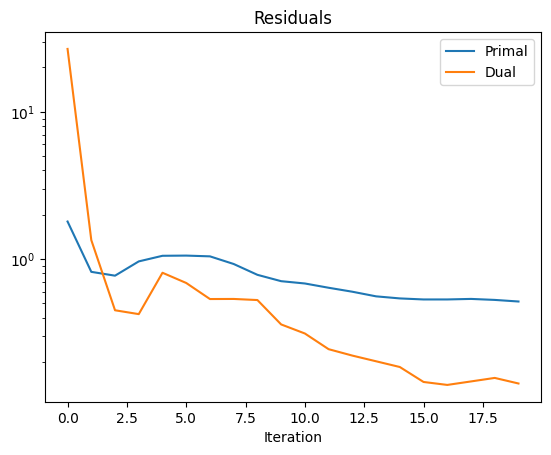

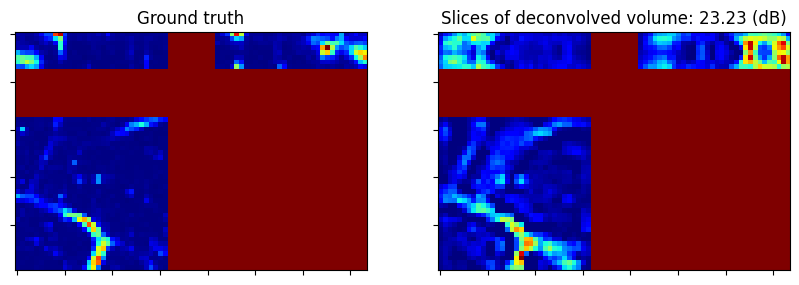

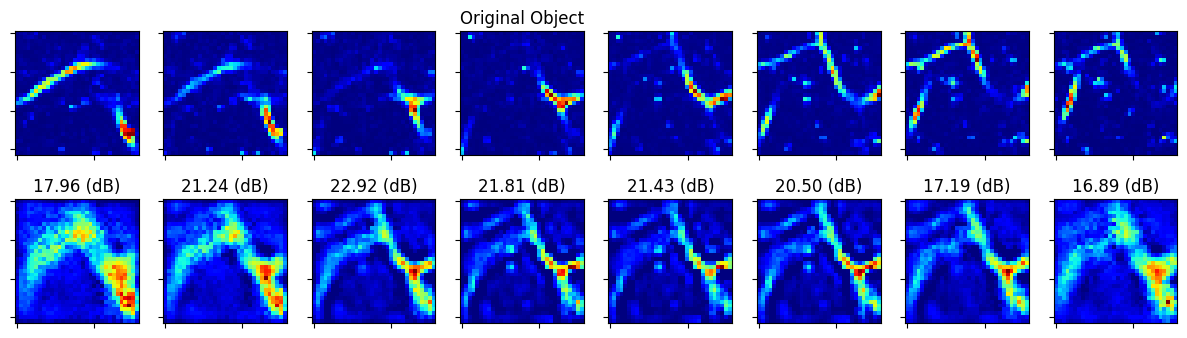

In [32]:
f = loss.SquaredL2Loss(y=y_noisy, A=A)
C = linop.Identity(x_gt.shape)

λ = .05 # BM4D regularization strength
g = λ * functional.DnCNN("17H")

ρ = 1  # ADMM penalty parameter
maxiter = 20  # number of ADMM iterations

x_init = (A.T @ y_noisy)
x_init = (x_init-x_init.min())/(x_init.max()-x_init.min())

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=x_init,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 100}),
    itstat_options={"display": True},
)

print(f"Solving on {device_info()}\n")
x = solver.solve()
x = snp.clip(x, 0, 1)
hist = solver.itstat_object.history(transpose=True)

plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
)


fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot.imview(tile_volume_slices(x_gt), title="Ground truth", fig=fig, ax=ax[0],cmap = 'jet')
plot.imview(tile_volume_slices(x,sep_width=10), title="Slices of deconvolved volume: %.2f (dB)" % metric.psnr(x_gt, x), fig=fig, ax=ax[1],cmap = 'jet' )
fig.show()

fig, ax = plot.subplots(nrows=2, ncols=8, figsize=(15, 4))
for i in range(8):
    if i==3:
        plot.imview(x_gt[i], fig=fig, ax=ax[0][i],cmap = "jet", title="Original Object")
    else:
        plot.imview(x_gt[i], fig=fig, ax=ax[0][i],cmap = "jet")
    plot.imview(x[i],fig=fig,ax=ax[1][i],cmap = "jet", title=f"{metric.psnr(x_gt[i], x[i]):.2f} (dB)")
    fig.show()